<a href="https://colab.research.google.com/github/zzl-hyun/laughter-detection/blob/yamnet/yamnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import json

In [ ]:


class DBDHighlightDetector:
    def __init__(self):
        print("YAMNet 모델 로딩 중...")
        self.model = hub.load('https://tfhub.dev/google/yamnet/1')

        # 웃음 및 감정 반응 관련 클래스들
        self.target_classes = {
            'laughter': ['Laughter', 'Giggle', 'Chuckle', 'Belly laugh', 'Snicker'],
            'excitement': ['Shout', 'Yell', 'Whoop', 'Cheering', 'Battle cry'],
            'surprise': ['Gasp', 'Scream', 'Shriek', 'Screaming'],
            'speech': ['Speech', 'Male speech, man speaking', 'Female speech, woman speaking']
        }

        # 클래스 이름을 인덱스로 매핑
        self.class_map = self._load_class_map()
        self.target_indices = self._get_target_indices()

        print("모델 로딩 완료!")

    def _load_class_map(self):
        """YAMNet 클래스 맵 로드"""
        class_map_path = self.model.class_map_path().numpy()
        class_names = [line.decode('utf-8') for line in tf.io.read_file(class_map_path).numpy().split(b'\n')]
        return {name.strip(): idx for idx, name in enumerate(class_names) if name.strip()}

    def _get_target_indices(self):
        """타겟 클래스들의 인덱스 반환"""
        indices = {}
        for category, class_list in self.target_classes.items():
            indices[category] = []
            for class_name in class_list:
                if class_name in self.class_map:
                    indices[category].append(self.class_map[class_name])
        return indices

    def load_audio(self, file_path):
        """오디오 파일 로드 및 전처리"""
        print(f"오디오 로딩: {file_path}")

        # librosa로 오디오 로드 (16kHz, mono)
        audio, sr = librosa.load(file_path, sr=16000, mono=True)

        # YAMNet 입력 형식으로 변환
        audio = tf.cast(audio, tf.float32)

        print(f"오디오 길이: {len(audio)/16000:.2f}초")
        return audio

    def analyze_audio(self, audio, threshold=0.3):
        """오디오 분석하여 웃음소리 및 감정 반응 감지"""
        print("오디오 분석 중...")

        # YAMNet으로 분석
        scores, embeddings, spectrogram = self.model(audio)

        # 시간 정보 생성 (0.48초 간격)
        times = np.arange(len(scores)) * 0.48

        results = []

        for i, (score, time) in enumerate(zip(scores.numpy(), times)):
            frame_result = {
                'time': time,
                'timestamp': str(timedelta(seconds=time)),
                'detections': {}
            }

            # 각 카테고리별 최대 확률 계산
            for category, class_indices in self.target_indices.items():
                if class_indices:  # 인덱스가 있는 경우만
                    category_scores = score[class_indices]
                    max_score = np.max(category_scores)
                    max_idx = np.argmax(category_scores)

                    if max_score > threshold:
                        # 해당 클래스 이름 찾기
                        detected_class_idx = class_indices[max_idx]
                        detected_class = None
                        for class_name, idx in self.class_map.items():
                            if idx == detected_class_idx:
                                detected_class = class_name
                                break

                        frame_result['detections'][category] = {
                            'score': float(max_score),
                            'class': detected_class,
                            'confidence': f"{max_score*100:.1f}%"
                        }

            # 감지된 것이 있으면 결과에 추가
            if frame_result['detections']:
                results.append(frame_result)

        print(f"총 {len(results)}개 구간에서 반응 감지")
        return results

    def merge_consecutive_detections(self, results, merge_window=2.0):
        """연속된 감지 결과들을 병합"""
        if not results:
            return []

        merged = []
        current_segment = {
            'start_time': results[0]['time'],
            'end_time': results[0]['time'],
            'detections': {},
            'max_scores': {}
        }

        for result in results:
            # 병합 윈도우 내에 있으면 현재 세그먼트에 추가
            if result['time'] - current_segment['end_time'] <= merge_window:
                current_segment['end_time'] = result['time']

                # 각 카테고리별 최대 점수 업데이트
                for category, detection in result['detections'].items():
                    if category not in current_segment['max_scores'] or \
                       detection['score'] > current_segment['max_scores'][category]:
                        current_segment['max_scores'][category] = detection['score']
                        current_segment['detections'][category] = detection
            else:
                # 새로운 세그먼트 시작
                merged.append(current_segment.copy())
                current_segment = {
                    'start_time': result['time'],
                    'end_time': result['time'],
                    'detections': result['detections'].copy(),
                    'max_scores': {cat: det['score'] for cat, det in result['detections'].items()}
                }

        merged.append(current_segment)
        return merged

    def extract_highlights(self, audio_file, output_dir="highlights", threshold=0.3):
        """하이라이트 구간 추출"""
        # 오디오 로드
        audio = self.load_audio(audio_file)

        # 분석
        results = self.analyze_audio(audio, threshold)

        if not results:
            print("감지된 하이라이트가 없습니다.")
            return []

        # 연속 구간 병합
        highlights = self.merge_consecutive_detections(results)

        # 결과 출력
        print(f"\n=== 하이라이트 감지 결과 ===")
        for i, highlight in enumerate(highlights, 1):
            start_str = str(timedelta(seconds=highlight['start_time']))
            end_str = str(timedelta(seconds=highlight['end_time']))
            duration = highlight['end_time'] - highlight['start_time']

            print(f"\n하이라이트 #{i}")
            print(f"시간: {start_str} ~ {end_str} (길이: {duration:.1f}초)")

            for category, detection in highlight['detections'].items():
                emoji = {'laughter': '😂', 'excitement': '🎉', 'surprise': '😱', 'speech': '🗣️'}
                print(f"  {emoji.get(category, '🔊')} {category}: {detection['class']} ({detection['confidence']})")

        return highlights

    def visualize_results(self, audio_file, highlights, save_path=None):
        """결과 시각화"""
        audio = self.load_audio(audio_file)

        # 오디오 파형 그리기
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # 파형 그래프
        time_axis = np.linspace(0, len(audio)/16000, len(audio))
        ax1.plot(time_axis, audio, alpha=0.6, color='blue')
        ax1.set_title('오디오 파형과 감지된 하이라이트')
        ax1.set_xlabel('시간 (초)')
        ax1.set_ylabel('진폭')

        # 하이라이트 구간 표시
        colors = {'laughter': 'red', 'excitement': 'orange', 'surprise': 'purple', 'speech': 'green'}

        for highlight in highlights:
            start, end = highlight['start_time'], highlight['end_time']

            # 가장 높은 점수의 카테고리 찾기
            main_category = max(highlight['detections'].keys(),
                              key=lambda x: highlight['detections'][x]['score'])

            color = colors.get(main_category, 'gray')
            ax1.axvspan(start, end, alpha=0.3, color=color,
                       label=f"{main_category.title()}" if main_category not in [l.get_text() for l in ax1.get_legend().get_texts() if ax1.get_legend()] else "")

        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 카테고리별 시간대 그래프
        categories = list(colors.keys())
        y_positions = range(len(categories))

        for i, category in enumerate(categories):
            for highlight in highlights:
                if category in highlight['detections']:
                    start, end = highlight['start_time'], highlight['end_time']
                    score = highlight['detections'][category]['score']
                    ax2.barh(i, end-start, left=start, height=0.6,
                            color=colors[category], alpha=score,
                            edgecolor='black', linewidth=0.5)

        ax2.set_yticks(y_positions)
        ax2.set_yticklabels([cat.title() for cat in categories])
        ax2.set_xlabel('시간 (초)')
        ax2.set_title('카테고리별 감지 결과')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"결과 그래프 저장: {save_path}")

        plt.show()

    def save_results(self, highlights, output_file="highlights_result.json"):
        """결과를 JSON 파일로 저장"""
        # datetime 객체를 문자열로 변환
        serializable_highlights = []
        for highlight in highlights:
            serializable_highlight = {
                'start_time': highlight['start_time'],
                'end_time': highlight['end_time'],
                'start_timestamp': str(timedelta(seconds=highlight['start_time'])),
                'end_timestamp': str(timedelta(seconds=highlight['end_time'])),
                'duration': highlight['end_time'] - highlight['start_time'],
                'detections': highlight['detections']
            }
            serializable_highlights.append(serializable_highlight)

        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(serializable_highlights, f, indent=2, ensure_ascii=False)

        print(f"결과 저장: {output_file}")


In [ ]:

# 사용 예제
def main():
    # 감지기 초기화
    detector = DBDHighlightDetector()

    # 오디오 파일 분석 (게이머 마이크 녹음본)
    # audio_file = "gamer_microphone_recording.wav"  # 실제 파일 경로로 변경
    # audio_file = "Host_Talk.MP3"  # 실제 파일 경로로 변경
    # audio_file = "Guest1_Talk.MP3"  # 실제 파일 경로로 변경
    # audio_file = "Guest2_Talk.MP3"  # 실제 파일 경로로 변경
    # audio_file = "Subs.m4a"  # 실제 파일 경로로 변경
    audio_file = "sample.m4a"  # 실제 파일 경로로 변경

    try:
        # 하이라이트 추출 (임계값 조정 가능: 0.2~0.5 추천)
        highlights = detector.extract_highlights(audio_file, threshold=0.15)

        if highlights:
            # 결과 시각화
            detector.visualize_results(audio_file, highlights, "dbd_highlights.png")

            # 결과 저장
            detector.save_results(highlights, "dbd_highlights.json")

            # 간단한 통계
            total_highlight_time = sum(h['end_time'] - h['start_time'] for h in highlights)
            print(f"\n=== 통계 ===")
            print(f"총 하이라이트 수: {len(highlights)}")
            print(f"총 하이라이트 시간: {total_highlight_time:.1f}초")

            # 카테고리별 통계
            category_counts = {}
            for highlight in highlights:
                for category in highlight['detections']:
                    category_counts[category] = category_counts.get(category, 0) + 1

            print("카테고리별 감지 횟수:")
            for category, count in category_counts.items():
                emoji = {'laughter': '😂', 'excitement': '🎉', 'surprise': '😱', 'speech': '🗣️'}
                print(f"  {emoji.get(category, '🔊')} {category}: {count}회")

    except Exception as e:
        print(f"오류 발생: {e}")
        print("오디오 파일 경로를 확인해주세요.")

if __name__ == "__main__":
    main()

YAMNet 모델 로딩 중...
모델 로딩 완료!
오디오 로딩: sample.m4a


/tmp/ipython-input-2-556800659.py:42: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=16000, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


오디오 길이: 7.72초
오디오 분석 중...
총 0개 구간에서 반응 감지
감지된 하이라이트가 없습니다.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import json

class DBDHighlightDetector:
    def __init__(self):
        """데드 바이 데이라이트 하이라이트 감지기 초기화"""
        print("YAMNet 모델 로딩 중...")
        self.model = hub.load('https://tfhub.dev/google/yamnet/1')

        # 웃음 및 감정 반응 관련 클래스들 (더 정확한 YAMNet 클래스명)
        self.target_classes = {
            'laughter': ['Laughter', 'Giggle', 'Snicker', 'Chuckle', 'Belly laugh'],
            'excitement': ['Shout', 'Yell', 'Whoop', 'Cheering', 'Battle cry', 'Scream'],
            'surprise': ['Gasp', 'Shriek', 'Screaming'],
            'speech': ['Speech', 'Male speech, man speaking', 'Female speech, woman speaking',
                      'Conversation', 'Narration, monologue']
        }

        # 클래스 이름을 인덱스로 매핑
        self.class_map = self._load_class_map()
        self.target_indices = self._get_target_indices()

        print("모델 로딩 완료!")

    def _load_class_map(self):
        """YAMNet 클래스 맵 로드"""
        class_map_path = self.model.class_map_path().numpy()
        class_names = [line.decode('utf-8') for line in tf.io.read_file(class_map_path).numpy().split(b'\n')]
        return {name.strip(): idx for idx, name in enumerate(class_names) if name.strip()}

    def _get_target_indices(self):
        """타겟 클래스들의 인덱스 반환"""
        indices = {}
        for category, class_list in self.target_classes.items():
            indices[category] = []
            for class_name in class_list:
                if class_name in self.class_map:
                    indices[category].append(self.class_map[class_name])
        return indices

    def load_audio(self, file_path):
        """오디오 파일 로드 및 전처리"""
        print(f"오디오 로딩: {file_path}")

        # librosa로 오디오 로드 (16kHz, mono)
        audio, sr = librosa.load(file_path, sr=16000, mono=True)

        # YAMNet 입력 형식으로 변환
        audio = tf.cast(audio, tf.float32)

        print(f"오디오 길이: {len(audio)/16000:.2f}초")
        return audio

    def debug_analysis(self, audio, num_frames=5):
        """디버깅용: 상위 점수 클래스들 확인"""
        print("=== 디버깅 모드: 실제 감지되는 클래스들 확인 ===")

        scores, embeddings, spectrogram = self.model(audio)
        times = np.arange(len(scores)) * 0.48

        # 처음 몇 프레임만 분석
        max_frames = min(num_frames, len(scores))

        for i in range(max_frames):
            score = scores[i].numpy()
            time = times[i]

            # 상위 10개 클래스 출력
            top_indices = np.argsort(score)[-10:][::-1]

            print(f"\n시간 {time:.1f}초 - 상위 감지 클래스들:")
            for j, idx in enumerate(top_indices):
                class_name = list(self.class_map.keys())[list(self.class_map.values()).index(idx)]
                print(f"  {j+1}. {class_name}: {score[idx]:.3f} ({score[idx]*100:.1f}%)")

        # 타겟 클래스들이 실제로 존재하는지 확인
        print(f"\n=== 타겟 클래스 존재 여부 확인 ===")
        for category, class_list in self.target_classes.items():
            found_classes = []
            for class_name in class_list:
                if class_name in self.class_map:
                    found_classes.append(class_name)
            print(f"{category}: {len(found_classes)}/{len(class_list)}개 발견 - {found_classes}")

    def analyze_audio(self, audio, threshold=0.3, debug=False):
        """오디오 분석하여 웃음소리 및 감정 반응 감지"""
        print("오디오 분석 중...")

        # YAMNet으로 분석
        scores, embeddings, spectrogram = self.model(audio)

        # 디버그 모드면 상세 정보 출력
        if debug:
            self.debug_analysis(audio)
            return []

        # 시간 정보 생성 (0.48초 간격)
        times = np.arange(len(scores)) * 0.48

        results = []
        all_detections = []  # 모든 감지 결과 저장 (디버깅용)

        for i, (score, time) in enumerate(zip(scores.numpy(), times)):
            frame_result = {
                'time': time,
                'timestamp': str(timedelta(seconds=time)),
                'detections': {}
            }

            # 전체 최고 점수도 기록 (디버깅용)
            max_overall_score = np.max(score)
            max_overall_idx = np.argmax(score)
            max_overall_class = list(self.class_map.keys())[list(self.class_map.values()).index(max_overall_idx)]

            all_detections.append({
                'time': time,
                'max_score': max_overall_score,
                'max_class': max_overall_class
            })

            # 각 카테고리별 최대 확률 계산
            for category, class_indices in self.target_indices.items():
                if class_indices:  # 인덱스가 있는 경우만
                    category_scores = score[class_indices]
                    max_score = np.max(category_scores)
                    max_idx = np.argmax(category_scores)

                    if max_score > threshold:
                        # 해당 클래스 이름 찾기
                        detected_class_idx = class_indices[max_idx]
                        detected_class = None
                        for class_name, idx in self.class_map.items():
                            if idx == detected_class_idx:
                                detected_class = class_name
                                break

                        frame_result['detections'][category] = {
                            'score': float(max_score),
                            'class': detected_class,
                            'confidence': f"{max_score*100:.1f}%"
                        }

            # 감지된 것이 있으면 결과에 추가
            if frame_result['detections']:
                results.append(frame_result)

        # 디버깅 정보 출력
        if len(results) == 0:
            print(f"\n⚠️  임계값 {threshold}로 감지된 결과가 없습니다!")
            print("디버깅 정보:")

            # 타겟 카테고리별 최고 점수 출력
            for category, class_indices in self.target_indices.items():
                if class_indices:
                    category_max_scores = []
                    for score in scores.numpy():
                        category_scores = score[class_indices]
                        category_max_scores.append(np.max(category_scores))

                    overall_max = np.max(category_max_scores)
                    print(f"  {category} 최고 점수: {overall_max:.3f} ({overall_max*100:.1f}%)")

            # 전체 최고 점수들
            overall_scores = [d['max_score'] for d in all_detections]
            print(f"  전체 최고 점수: {np.max(overall_scores):.3f}")
            print(f"  권장 임계값: {np.max(overall_scores) * 0.7:.3f}")

        print(f"총 {len(results)}개 구간에서 반응 감지")
        return results

    def merge_consecutive_detections(self, results, merge_window=2.0):
        """연속된 감지 결과들을 병합"""
        if not results:
            return []

        merged = []
        current_segment = {
            'start_time': results[0]['time'],
            'end_time': results[0]['time'],
            'detections': {},
            'max_scores': {}
        }

        for result in results:
            # 병합 윈도우 내에 있으면 현재 세그먼트에 추가
            if result['time'] - current_segment['end_time'] <= merge_window:
                current_segment['end_time'] = result['time']

                # 각 카테고리별 최대 점수 업데이트
                for category, detection in result['detections'].items():
                    if category not in current_segment['max_scores'] or \
                       detection['score'] > current_segment['max_scores'][category]:
                        current_segment['max_scores'][category] = detection['score']
                        current_segment['detections'][category] = detection
            else:
                # 새로운 세그먼트 시작
                merged.append(current_segment.copy())
                current_segment = {
                    'start_time': result['time'],
                    'end_time': result['time'],
                    'detections': result['detections'].copy(),
                    'max_scores': {cat: det['score'] for cat, det in result['detections'].items()}
                }

        merged.append(current_segment)
        return merged

    def extract_highlights(self, audio_file, output_dir="highlights", threshold=0.3, debug=False):
        """하이라이트 구간 추출"""
        # 오디오 로드
        audio = self.load_audio(audio_file)

        # 디버그 모드면 상세 분석만 하고 종료
        if debug:
            print("🔍 디버그 모드: 실제 감지되는 클래스들을 확인합니다...")
            self.analyze_audio(audio, threshold, debug=True)
            return []

        # 분석
        results = self.analyze_audio(audio, threshold, debug=False)

        if not results:
            print("😞 감지된 하이라이트가 없습니다.")
            print("\n💡 해결 방법:")
            print("1. 더 낮은 임계값 시도: threshold=0.1 또는 0.05")
            print("2. 디버그 모드로 실행: debug=True")
            print("3. 오디오에 실제 음성이나 웃음이 있는지 확인")

            # 자동으로 낮은 임계값 시도
            print(f"\n🔄 임계값 {threshold*0.5:.2f}로 재시도...")
            results = self.analyze_audio(audio, threshold*0.5, debug=False)

            if not results:
                print(f"🔄 임계값 {threshold*0.2:.2f}로 재시도...")
                results = self.analyze_audio(audio, threshold*0.2, debug=False)

        if not results:
            print("❌ 매우 낮은 임계값으로도 감지되지 않았습니다.")
            print("debug=True로 실행해서 문제를 확인해보세요.")
            return []

        # 연속 구간 병합
        highlights = self.merge_consecutive_detections(results)

        # 결과 출력
        print(f"\n=== 하이라이트 감지 결과 ===")
        for i, highlight in enumerate(highlights, 1):
            start_str = str(timedelta(seconds=highlight['start_time']))
            end_str = str(timedelta(seconds=highlight['end_time']))
            duration = highlight['end_time'] - highlight['start_time']

            print(f"\n하이라이트 #{i}")
            print(f"시간: {start_str} ~ {end_str} (길이: {duration:.1f}초)")

            for category, detection in highlight['detections'].items():
                emoji = {'laughter': '😂', 'excitement': '🎉', 'surprise': '😱', 'speech': '🗣️'}
                print(f"  {emoji.get(category, '🔊')} {category}: {detection['class']} ({detection['confidence']})")

        return highlights

    def visualize_results(self, audio_file, highlights, save_path=None):
        """결과 시각화"""
        audio = self.load_audio(audio_file)

        # 오디오 파형 그리기
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # 파형 그래프
        time_axis = np.linspace(0, len(audio)/16000, len(audio))
        ax1.plot(time_axis, audio, alpha=0.6, color='blue')
        ax1.set_title('오디오 파형과 감지된 하이라이트')
        ax1.set_xlabel('시간 (초)')
        ax1.set_ylabel('진폭')

        # 하이라이트 구간 표시
        colors = {'laughter': 'red', 'excitement': 'orange', 'surprise': 'purple', 'speech': 'green'}

        for highlight in highlights:
            start, end = highlight['start_time'], highlight['end_time']

            # 가장 높은 점수의 카테고리 찾기
            main_category = max(highlight['detections'].keys(),
                              key=lambda x: highlight['detections'][x]['score'])

            color = colors.get(main_category, 'gray')
            ax1.axvspan(start, end, alpha=0.3, color=color,
                       label=f"{main_category.title()}" if main_category not in [l.get_text() for l in ax1.get_legend().get_texts() if ax1.get_legend()] else "")

        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 카테고리별 시간대 그래프
        categories = list(colors.keys())
        y_positions = range(len(categories))

        for i, category in enumerate(categories):
            for highlight in highlights:
                if category in highlight['detections']:
                    start, end = highlight['start_time'], highlight['end_time']
                    score = highlight['detections'][category]['score']
                    ax2.barh(i, end-start, left=start, height=0.6,
                            color=colors[category], alpha=score,
                            edgecolor='black', linewidth=0.5)

        ax2.set_yticks(y_positions)
        ax2.set_yticklabels([cat.title() for cat in categories])
        ax2.set_xlabel('시간 (초)')
        ax2.set_title('카테고리별 감지 결과')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"결과 그래프 저장: {save_path}")

        plt.show()

    def save_results(self, highlights, output_file="highlights_result.json"):
        """결과를 JSON 파일로 저장"""
        # datetime 객체를 문자열로 변환
        serializable_highlights = []
        for highlight in highlights:
            serializable_highlight = {
                'start_time': highlight['start_time'],
                'end_time': highlight['end_time'],
                'start_timestamp': str(timedelta(seconds=highlight['start_time'])),
                'end_timestamp': str(timedelta(seconds=highlight['end_time'])),
                'duration': highlight['end_time'] - highlight['start_time'],
                'detections': highlight['detections']
            }
            serializable_highlights.append(serializable_highlight)

        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(serializable_highlights, f, indent=2, ensure_ascii=False)

        print(f"결과 저장: {output_file}")

# 사용 예제
def main():
    # 감지기 초기화
    detector = DBDHighlightDetector()

    # 오디오 파일 분석 (게이머 마이크 녹음본)
    # audio_file = "gamer_microphone_recording.wav"  # 실제 파일 경로로 변경
    # audio_file = "Host_Talk.MP3"  # 실제 파일 경로로 변경
    # audio_file = "Guest1_Talk.MP3"  # 실제 파일 경로로 변경
    # audio_file = "Guest2_Talk.MP3"  # 실제 파일 경로로 변경
    # audio_file = "Subs.m4a"  # 실제 파일 경로로 변경
    # audio_file = "sample2.m4a"  # 실제 파일 경로로 변경
    audio_file = "sample3.mp3"  # 실제 파일 경로로 변경

    print("🎮 데바데 하이라이트 감지기")
    print("=" * 50)

    try:
        # 🔍 STEP 1: 디버그 모드로 먼저 확인
        print("STEP 1: 디버그 모드로 오디오 분석...")
        detector.extract_highlights(audio_file, debug=True)

        print("\n" + "="*50)
        input("디버그 결과를 확인하고 Enter를 눌러 계속...")

        # 🎯 STEP 2: 실제 하이라이트 추출 (낮은 임계값부터)
        print("STEP 2: 하이라이트 추출 시도...")

        # 여러 임계값으로 시도
        thresholds = [0.1, 0.05, 0.15, 0.2]
        highlights = None

        for threshold in thresholds:
            print(f"\n🎯 임계값 {threshold}로 시도...")
            highlights = detector.extract_highlights(audio_file, threshold=threshold)
            if highlights:
                print(f"✅ 임계값 {threshold}에서 {len(highlights)}개 하이라이트 발견!")
                break

        if highlights:
            # 결과 시각화
            detector.visualize_results(audio_file, highlights, "dbd_highlights.png")

            # 결과 저장
            detector.save_results(highlights, "dbd_highlights.json")

            # 간단한 통계
            total_highlight_time = sum(h['end_time'] - h['start_time'] for h in highlights)
            print(f"\n=== 📊 통계 ===")
            print(f"총 하이라이트 수: {len(highlights)}")
            print(f"총 하이라이트 시간: {total_highlight_time:.1f}초")

            # 카테고리별 통계
            category_counts = {}
            for highlight in highlights:
                for category in highlight['detections']:
                    category_counts[category] = category_counts.get(category, 0) + 1

            print("카테고리별 감지 횟수:")
            for category, count in category_counts.items():
                emoji = {'laughter': '😂', 'excitement': '🎉', 'surprise': '😱', 'speech': '🗣️'}
                print(f"  {emoji.get(category, '🔊')} {category}: {count}회")
        else:
            print("\n❌ 모든 임계값에서 감지 실패")
            print("\n🔧 문제 해결 방법:")
            print("1. 오디오 파일에 실제 음성/웃음이 포함되어 있는지 확인")
            print("2. 오디오 볼륨이 너무 작지 않은지 확인")
            print("3. 배경음악이 너무 크지 않은지 확인")
            print("4. 마이크 녹음이 제대로 되었는지 확인")

    except FileNotFoundError:
        print("❌ 오디오 파일을 찾을 수 없습니다!")
        print("파일 경로를 확인해주세요.")
        print("\n💡 지원되는 파일 형식:")
        print("- MP3, WAV, FLAC, M4A, OGG 등")

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print("\n🔧 해결 방법:")
        print("1. 필요한 라이브러리 설치: pip install tensorflow tensorflow-hub librosa")
        print("2. 인터넷 연결 확인 (YAMNet 모델 다운로드)")
        print("3. 오디오 파일 형식 확인")

# 빠른 테스트용 함수
def quick_test(audio_file, threshold=0.6):
    """빠른 테스트용"""
    detector = DBDHighlightDetector()
    highlights = detector.extract_highlights(audio_file, threshold=threshold)
    return highlights

# 디버그 전용 함수
def debug_only(audio_file):
    """디버그만 실행"""
    detector = DBDHighlightDetector()
    detector.extract_highlights(audio_file, debug=True)

# 간단한 사용법
def simple_usage_example():
    """간단한 사용 예제"""
    print("🚀 간단한 사용법:")
    print("1. 디버그 모드:")
    print("   debug_only('your_audio.mp3')")
    print()
    print("2. 빠른 테스트:")
    print("   quick_test('your_audio.mp3', threshold=0.05)")
    print()
    print("3. 전체 분석:")
    print("   detector = DBDHighlightDetector()")
    print("   highlights = detector.extract_highlights('your_audio.mp3')")

if __name__ == "__main__":
    main()

YAMNet 모델 로딩 중...
모델 로딩 완료!
🎮 데바데 하이라이트 감지기
STEP 1: 디버그 모드로 오디오 분석...
오디오 로딩: sample3.mp3
오디오 길이: 1248.79초
🔍 디버그 모드: 실제 감지되는 클래스들을 확인합니다...
오디오 분석 중...
=== 디버깅 모드: 실제 감지되는 클래스들 확인 ===

시간 0.0초 - 상위 감지 클래스들:
  1. index,mid,display_name: 0.983 (98.3%)
  2. 131,/m/032n05,Whale vocalization: 0.016 (1.6%)
  3. 499,/m/07pt_g0,Pulse: 0.010 (1.0%)
  4. 246,/m/0155w,Blues: 0.008 (0.8%)
  5. 0,/m/09x0r,Speech: 0.007 (0.7%)
  6. 1,/m/0ytgt,"Child speech, kid speaking": 0.006 (0.6%)
  7. 500,/t/dd00125,"Inside, small room": 0.003 (0.3%)
  8. 503,/t/dd00128,"Outside, urban or manmade": 0.002 (0.2%)
  9. 2,/m/01h8n0,Conversation: 0.001 (0.1%)
  10. 502,/t/dd00127,"Inside, public space": 0.001 (0.1%)

시간 0.5초 - 상위 감지 클래스들:
  1. index,mid,display_name: 0.996 (99.6%)
  2. 2,/m/01h8n0,Conversation: 0.006 (0.6%)
  3. 499,/m/07pt_g0,Pulse: 0.004 (0.4%)
  4. 1,/m/0ytgt,"Child speech, kid speaking": 0.002 (0.2%)
  5. 500,/t/dd00125,"Inside, small room": 0.002 (0.2%)
  6. 0,/m/09x0r,Speech: 0.002 (0.2%)
  7.

In [ ]:
!pip install tensorflow tensorflow-hub librosa

YAMNet 모델 로딩 중...
모델 로딩 완료!
🎮 데바데 하이라이트 감지기
STEP 1: 디버그 모드로 오디오 분석...
오디오 로딩: sample3.mp3
오디오 길이: 1248.79초
🔍 디버그 모드: 실제 감지되는 클래스들을 확인합니다...
오디오 분석 중...
=== 디버깅 모드: 실제 감지되는 클래스들 확인 ===
YAMNet 총 클래스 수: 521

시간 0.0초 - 상위 감지 클래스들:
  1. Speech: 0.983 (98.3%)
  2. Music: 0.016 (1.6%)
  3. Inside, small room: 0.010 (1.0%)
  4. Music for children: 0.008 (0.8%)
  5. Child speech, kid speaking: 0.007 (0.7%)
  6. Conversation: 0.006 (0.6%)
  7. Inside, large room or hall: 0.003 (0.3%)
  8. Outside, rural or natural: 0.002 (0.2%)
  9. Narration, monologue: 0.001 (0.1%)
  10. Outside, urban or manmade: 0.001 (0.1%)

시간 0.5초 - 상위 감지 클래스들:
  1. Speech: 0.996 (99.6%)
  2. Narration, monologue: 0.006 (0.6%)
  3. Inside, small room: 0.004 (0.4%)
  4. Conversation: 0.002 (0.2%)
  5. Inside, large room or hall: 0.002 (0.2%)
  6. Child speech, kid speaking: 0.002 (0.2%)
  7. Outside, rural or natural: 0.001 (0.1%)
  8. Outside, urban or manmade: 0.001 (0.1%)
  9. Speech synthesizer: 0.000 (0.0%)
  10. Musi

/tmp/ipython-input-12-1988689331.py:425: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipython-input-12-1988689331.py:429: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


결과 그래프 저장: dbd_highlights.png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


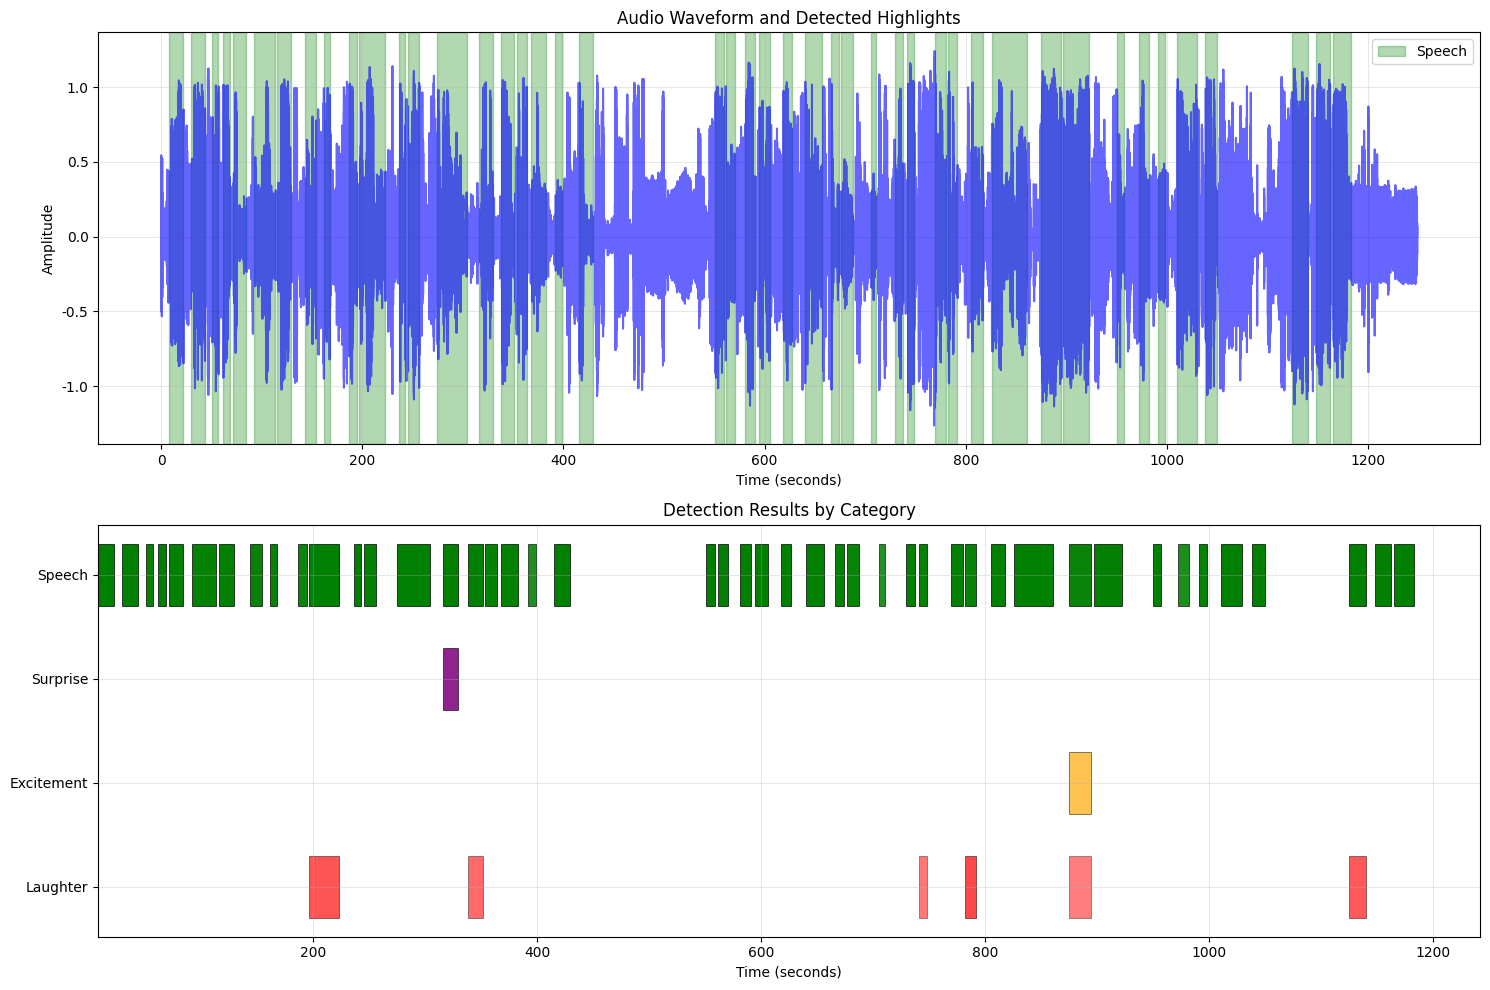


=== 📊 통계 ===
총 하이라이트 수: 45
총 하이라이트 시간: 577.4초
카테고리별 감지 횟수:
  🗣️ speech: 45회
  😂 laughter: 6회
  😱 surprise: 1회
  🎉 excitement: 1회


In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import json
import csv
import io

class DBDHighlightDetector:
    def __init__(self):
        print("YAMNet 모델 로딩 중...")
        self.model = hub.load('https://tfhub.dev/google/yamnet/1')

        # 실제 YAMNet AudioSet 클래스명으로 수정
        self.target_classes = {
            'laughter': ['Laughter', 'Giggle', 'Snicker', 'Chuckle'],
            'excitement': ['Shout', 'Yell', 'Whoop', 'Cheering', 'Screaming'],
            'surprise': ['Gasp', 'Shriek'],
            'speech': ['Speech', 'Child speech, kid speaking', 'Female speech, woman speaking',
                      'Male speech, man speaking', 'Conversation', 'Narration, monologue']
        }

        # 클래스 이름을 인덱스로 매핑
        self.class_map = self._load_class_map()
        self.target_indices = self._get_target_indices()

        print("모델 로딩 완료!")

    def _load_class_map(self):
        """YAMNet 클래스 맵 로드 (수정된 버전)"""
        try:
            # 방법 1: class_map_path 사용
            class_map_path = self.model.class_map_path().numpy().decode('utf-8')

            # CSV 파일 읽기
            with tf.io.gfile.GFile(class_map_path, 'r') as f:
                csv_content = f.read()

            # CSV 파싱
            reader = csv.DictReader(io.StringIO(csv_content))
            class_names = []

            for row in reader:
                # display_name 컬럼 사용
                if 'display_name' in row:
                    class_names.append(row['display_name'])
                elif len(row) >= 3:  # fallback
                    class_names.append(list(row.values())[2])

            return {name: idx for idx, name in enumerate(class_names) if name}

        except Exception as e:
            print(f"클래스 맵 로딩 중 오류: {e}")
            # 대체 방법: 직접 클래스 이름 리스트 사용
            return self._get_fallback_class_map()

    def _get_fallback_class_map(self):
        """대체 클래스 맵 (YAMNet AudioSet 클래스 일부)"""
        # YAMNet에서 사용하는 주요 AudioSet 클래스들
        audioset_classes = [
            "Speech", "Male speech, man speaking", "Female speech, woman speaking",
            "Child speech, kid speaking", "Conversation", "Narration, monologue",
            "Babbling", "Speech synthesizer", "Shout", "Bellow", "Whoop", "Yell",
            "Children shouting", "Screaming", "Whispering", "Laughter", "Baby laughter",
            "Giggle", "Snicker", "Belly laugh", "Chuckle, chortle", "Crying, sobbing",
            "Baby cry, infant cry", "Whimper", "Wail, moan", "Sigh", "Singing",
            "Choir", "Yodeling", "Chant", "Mantra", "Male singing", "Female singing",
            "Child singing", "Synthetic singing", "Rapping", "Humming", "Groan",
            "Grunt", "Whistling", "Breathing", "Wheeze", "Snoring", "Gasp",
            "Pant", "Snort", "Cough", "Throat clearing", "Sneeze", "Sniff",
            "Run", "Shuffle", "Walk, footsteps", "Chewing, mastication", "Biting",
            "Gargling", "Stomach rumble", "Burping, eructation", "Hiccup", "Fart",
            "Hands", "Finger snapping", "Clapping", "Heart sounds, heartbeat",
            "Heart murmur", "Cheering", "Applause", "Chatter", "Crowd",
            "Hubbub, speech noise, speech babble"
        ]

        return {name: idx for idx, name in enumerate(audioset_classes)}

    def _get_target_indices(self):
        """타겟 클래스들의 인덱스 반환"""
        indices = {}
        for category, class_list in self.target_classes.items():
            indices[category] = []
            for class_name in class_list:
                if class_name in self.class_map:
                    indices[category].append(self.class_map[class_name])
        return indices

    def load_audio(self, file_path):
        """오디오 파일 로드 및 전처리"""
        print(f"오디오 로딩: {file_path}")

        # librosa로 오디오 로드 (16kHz, mono)
        audio, sr = librosa.load(file_path, sr=16000, mono=True)

        # YAMNet 입력 형식으로 변환
        audio = tf.cast(audio, tf.float32)

        print(f"오디오 길이: {len(audio)/16000:.2f}초")
        return audio

    def debug_analysis(self, audio, num_frames=5):
        """디버깅용: 상위 점수 클래스들 확인"""
        print("=== 디버깅 모드: 실제 감지되는 클래스들 확인 ===")

        scores, embeddings, spectrogram = self.model(audio)
        times = np.arange(len(scores)) * 0.48

        # 클래스 이름 가져오기 (수정된 방법)
        class_names = list(self.class_map.keys())

        # 처음 몇 프레임만 분석
        max_frames = min(num_frames, len(scores))

        print(f"YAMNet 총 클래스 수: {len(class_names)}")

        for i in range(max_frames):
            score = scores[i].numpy()
            time = times[i]

            # 상위 10개 클래스 출력
            top_indices = np.argsort(score)[-10:][::-1]

            print(f"\n시간 {time:.1f}초 - 상위 감지 클래스들:")
            for j, idx in enumerate(top_indices):
                if idx < len(class_names):
                    class_name = class_names[idx]
                    print(f"  {j+1}. {class_name}: {score[idx]:.3f} ({score[idx]*100:.1f}%)")

        # 타겟 클래스들이 실제로 존재하는지 확인
        print(f"\n=== 타겟 클래스 존재 여부 확인 ===")
        for category, class_list in self.target_classes.items():
            found_classes = []
            for class_name in class_list:
                if class_name in self.class_map:
                    found_classes.append(class_name)
            print(f"{category}: {len(found_classes)}/{len(class_list)}개 발견 - {found_classes}")

        # 유사한 클래스들 찾기
        print(f"\n=== 관련 클래스 검색 ===")
        keywords = ['laugh', 'speech', 'talk', 'voice', 'shout', 'scream', 'yell', 'conversation']
        for keyword in keywords:
            matches = [name for name in class_names if keyword.lower() in name.lower()]
            if matches:
                print(f"{keyword}: {matches}")

    def analyze_audio(self, audio, threshold=0.3, debug=False):
        """오디오 분석하여 웃음소리 및 감정 반응 감지"""
        print("오디오 분석 중...")

        # YAMNet으로 분석
        scores, embeddings, spectrogram = self.model(audio)

        # 디버그 모드면 상세 정보 출력
        if debug:
            self.debug_analysis(audio)
            return []

        # 시간 정보 생성 (0.48초 간격)
        times = np.arange(len(scores)) * 0.48

        results = []
        all_detections = []  # 모든 감지 결과 저장 (디버깅용)

        for i, (score, time) in enumerate(zip(scores.numpy(), times)):
            frame_result = {
                'time': time,
                'timestamp': str(timedelta(seconds=time)),
                'detections': {}
            }

            # 전체 최고 점수도 기록 (디버깅용)
            max_overall_score = np.max(score)
            max_overall_idx = np.argmax(score)

            # 클래스 이름 찾기 (수정된 방법)
            class_names = list(self.class_map.keys())
            if max_overall_idx < len(class_names):
                max_overall_class = class_names[max_overall_idx]
            else:
                max_overall_class = f"Unknown_Class_{max_overall_idx}"

            all_detections.append({
                'time': time,
                'max_score': max_overall_score,
                'max_class': max_overall_class
            })

            # 각 카테고리별 최대 확률 계산
            for category, class_indices in self.target_indices.items():
                if class_indices:  # 인덱스가 있는 경우만
                    # 유효한 인덱스만 사용
                    valid_indices = [idx for idx in class_indices if idx < len(score)]
                    if valid_indices:
                        category_scores = score[valid_indices]
                        max_score = np.max(category_scores)
                        max_idx = np.argmax(category_scores)

                        if max_score > threshold:
                            # 해당 클래스 이름 찾기
                            detected_class_idx = valid_indices[max_idx]
                            detected_class = None
                            for class_name, idx in self.class_map.items():
                                if idx == detected_class_idx:
                                    detected_class = class_name
                                    break

                            if detected_class is None:
                                detected_class = f"Class_{detected_class_idx}"

                            frame_result['detections'][category] = {
                                'score': float(max_score),
                                'class': detected_class,
                                'confidence': f"{max_score*100:.1f}%"
                            }

            # 감지된 것이 있으면 결과에 추가
            if frame_result['detections']:
                results.append(frame_result)

        # 디버깅 정보 출력
        if len(results) == 0:
            print(f"\n⚠️  임계값 {threshold}로 감지된 결과가 없습니다!")
            print("디버깅 정보:")

            # 타겟 카테고리별 최고 점수 출력
            for category, class_indices in self.target_indices.items():
                if class_indices:
                    category_max_scores = []
                    for score in scores.numpy():
                        valid_indices = [idx for idx in class_indices if idx < len(score)]
                        if valid_indices:
                            category_scores = score[valid_indices]
                            category_max_scores.append(np.max(category_scores))

                    if category_max_scores:
                        overall_max = np.max(category_max_scores)
                        print(f"  {category} 최고 점수: {overall_max:.3f} ({overall_max*100:.1f}%)")

            # 전체 최고 점수들
            if all_detections:
                overall_scores = [d['max_score'] for d in all_detections]
                print(f"  전체 최고 점수: {np.max(overall_scores):.3f}")
                print(f"  권장 임계값: {np.max(overall_scores) * 0.7:.3f}")

        print(f"총 {len(results)}개 구간에서 반응 감지")
        return results

    def filter_by_duration(self, highlights, min_duration=5.0):
        """최소 길이 기준으로 하이라이트 필터링"""
        filtered_highlights = []

        for highlight in highlights:
            duration = highlight['end_time'] - highlight['start_time']
            if duration >= min_duration:
                filtered_highlights.append(highlight)

        return filtered_highlights

    def merge_consecutive_detections(self, results, merge_window=2.0):
        """연속된 감지 결과들을 병합"""
        if not results:
            return []

        merged = []
        current_segment = {
            'start_time': results[0]['time'],
            'end_time': results[0]['time'],
            'detections': {},
            'max_scores': {}
        }

        for result in results:
            # 병합 윈도우 내에 있으면 현재 세그먼트에 추가
            if result['time'] - current_segment['end_time'] <= merge_window:
                current_segment['end_time'] = result['time']

                # 각 카테고리별 최대 점수 업데이트
                for category, detection in result['detections'].items():
                    if category not in current_segment['max_scores'] or \
                       detection['score'] > current_segment['max_scores'][category]:
                        current_segment['max_scores'][category] = detection['score']
                        current_segment['detections'][category] = detection
            else:
                # 새로운 세그먼트 시작
                merged.append(current_segment.copy())
                current_segment = {
                    'start_time': result['time'],
                    'end_time': result['time'],
                    'detections': result['detections'].copy(),
                    'max_scores': {cat: det['score'] for cat, det in result['detections'].items()}
                }

        merged.append(current_segment)
        return merged

    def extract_highlights(self, audio_file, output_dir="highlights", threshold=0.3, min_duration=5.0, debug=False):
        """하이라이트 구간 추출"""
        # 오디오 로드
        audio = self.load_audio(audio_file)

        # 디버그 모드면 상세 분석만 하고 종료
        if debug:
            print("🔍 디버그 모드: 실제 감지되는 클래스들을 확인합니다...")
            self.analyze_audio(audio, threshold, debug=True)
            return []

        # 분석
        results = self.analyze_audio(audio, threshold, debug=False)

        if not results:
            print("😞 감지된 하이라이트가 없습니다.")
            print("\n💡 해결 방법:")
            print("1. 더 낮은 임계값 시도: threshold=0.1 또는 0.05")
            print("2. 디버그 모드로 실행: debug=True")
            print("3. 오디오에 실제 음성이나 웃음이 있는지 확인")

            # 자동으로 낮은 임계값 시도
            print(f"\n🔄 임계값 {threshold*0.5:.2f}로 재시도...")
            results = self.analyze_audio(audio, threshold*0.5, debug=False)

            if not results:
                print(f"🔄 임계값 {threshold*0.2:.2f}로 재시도...")
                results = self.analyze_audio(audio, threshold*0.2, debug=False)

        if not results:
            print("❌ 매우 낮은 임계값으로도 감지되지 않았습니다.")
            print("debug=True로 실행해서 문제를 확인해보세요.")
            return []

        # 연속 구간 병합
        highlights = self.merge_consecutive_detections(results)

        # 최소 길이 필터링
        original_count = len(highlights)
        highlights = self.filter_by_duration(highlights, min_duration)
        filtered_count = original_count - len(highlights)

        if filtered_count > 0:
            print(f"\n⚠️  {min_duration}초 미만의 짧은 하이라이트 {filtered_count}개 제거됨")

        # 결과 출력
        print(f"\n=== 하이라이트 감지 결과 ({min_duration}초 이상만) ===")
        for i, highlight in enumerate(highlights, 1):
            start_str = str(timedelta(seconds=highlight['start_time']))
            end_str = str(timedelta(seconds=highlight['end_time']))
            duration = highlight['end_time'] - highlight['start_time']

            print(f"\n하이라이트 #{i}")
            print(f"시간: {start_str} ~ {end_str} (길이: {duration:.1f}초)")

            for category, detection in highlight['detections'].items():
                emoji = {'laughter': '😂', 'excitement': '🎉', 'surprise': '😱', 'speech': '🗣️'}
                print(f"  {emoji.get(category, '🔊')} {category}: {detection['class']} ({detection['confidence']})")

        return highlights

    def visualize_results(self, audio_file, highlights, save_path=None):
        """결과 시각화"""
        try:
            # 한글 폰트 설정
            plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
            plt.rcParams['axes.unicode_minus'] = False

            audio = self.load_audio(audio_file)

            # 오디오 파형 그리기
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

            # 파형 그래프
            time_axis = np.linspace(0, len(audio)/16000, len(audio))
            ax1.plot(time_axis, audio, alpha=0.6, color='blue')
            ax1.set_title('Audio Waveform and Detected Highlights')  # 영어로 변경
            ax1.set_xlabel('Time (seconds)')
            ax1.set_ylabel('Amplitude')

            # 하이라이트 구간 표시
            colors = {'laughter': 'red', 'excitement': 'orange', 'surprise': 'purple', 'speech': 'green'}
            added_labels = set()  # 이미 추가된 라벨 추적

            for highlight in highlights:
                start, end = highlight['start_time'], highlight['end_time']

                # 가장 높은 점수의 카테고리 찾기
                main_category = max(highlight['detections'].keys(),
                                  key=lambda x: highlight['detections'][x]['score'])

                color = colors.get(main_category, 'gray')

                # 라벨은 처음에만 추가
                label = f"{main_category.title()}" if main_category not in added_labels else ""
                if label:
                    added_labels.add(main_category)

                ax1.axvspan(start, end, alpha=0.3, color=color, label=label)

            # 범례가 있는 경우에만 표시
            if added_labels:
                ax1.legend()
            ax1.grid(True, alpha=0.3)

            # 카테고리별 시간대 그래프
            categories = list(colors.keys())
            y_positions = range(len(categories))

            for i, category in enumerate(categories):
                for highlight in highlights:
                    if category in highlight['detections']:
                        start, end = highlight['start_time'], highlight['end_time']
                        score = highlight['detections'][category]['score']
                        ax2.barh(i, end-start, left=start, height=0.6,
                                color=colors[category], alpha=score,
                                edgecolor='black', linewidth=0.5)

            ax2.set_yticks(y_positions)
            ax2.set_yticklabels([cat.title() for cat in categories])
            ax2.set_xlabel('Time (seconds)')
            ax2.set_title('Detection Results by Category')
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()

            if save_path:
                try:
                    plt.savefig(save_path, dpi=300, bbox_inches='tight')
                    print(f"결과 그래프 저장: {save_path}")
                except Exception as save_error:
                    print(f"그래프 저장 중 오류: {save_error}")

            plt.show()

        except Exception as e:
            print(f"시각화 중 오류 발생: {e}")
            print("시각화를 건너뛰고 계속 진행합니다...")
            return

    def save_results(self, highlights, output_file="highlights_result.json"):
        """결과를 JSON 파일로 저장"""
        # datetime 객체를 문자열로 변환
        serializable_highlights = []
        for highlight in highlights:
            serializable_highlight = {
                'start_time': highlight['start_time'],
                'end_time': highlight['end_time'],
                'start_timestamp': str(timedelta(seconds=highlight['start_time'])),
                'end_timestamp': str(timedelta(seconds=highlight['end_time'])),
                'duration': highlight['end_time'] - highlight['start_time'],
                'detections': highlight['detections']
            }
            serializable_highlights.append(serializable_highlight)

        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(serializable_highlights, f, indent=2, ensure_ascii=False)

        print(f"결과 저장: {output_file}")

# 사용 예제
def main():
    # 감지기 초기화
    detector = DBDHighlightDetector()

    # 오디오 파일 분석 (게이머 마이크 녹음본)
    audio_file = "Clip1_Guest1_Talk.MP3"  # 실제 파일 경로로 변경
    audio_file = "sample3.mp3"  # 실제 파일 경로로 변경

    print("🎮 데바데 하이라이트 감지기")
    print("=" * 50)

    try:
        # 🔍 STEP 1: 디버그 모드로 먼저 확인
        print("STEP 1: 디버그 모드로 오디오 분석...")
        detector.extract_highlights(audio_file, debug=True)

        print("\n" + "="*50)
        input("디버그 결과를 확인하고 Enter를 눌러 계속...")

        # 🎯 STEP 2: 실제 하이라이트 추출 (낮은 임계값부터)
        print("STEP 2: 하이라이트 추출 시도...")

        # 여러 임계값으로 시도
        thresholds = [0.5, 0.05, 0.15, 0.2]
        highlights = None

        for threshold in thresholds:
            print(f"\n🎯 임계값 {threshold}로 시도...")
            highlights = detector.extract_highlights(audio_file, threshold=threshold, min_duration=5.0)
            if highlights:
                print(f"✅ 임계값 {threshold}에서 {len(highlights)}개 하이라이트 발견!")
                break

        if highlights:
            # 결과 저장
            detector.save_results(highlights, "dbd_highlights.json")

            # 결과 시각화 (오류가 발생해도 계속 진행)
            try:
                detector.visualize_results(audio_file, highlights, "dbd_highlights.png")
            except Exception as viz_error:
                print(f"시각화 건너뛰기: {viz_error}")

            # 간단한 통계
            total_highlight_time = sum(h['end_time'] - h['start_time'] for h in highlights)
            print(f"\n=== 📊 통계 ===")
            print(f"총 하이라이트 수: {len(highlights)}")
            print(f"총 하이라이트 시간: {total_highlight_time:.1f}초")

            # 카테고리별 통계
            category_counts = {}
            for highlight in highlights:
                for category in highlight['detections']:
                    category_counts[category] = category_counts.get(category, 0) + 1

            print("카테고리별 감지 횟수:")
            for category, count in category_counts.items():
                emoji = {'laughter': '😂', 'excitement': '🎉', 'surprise': '😱', 'speech': '🗣️'}
                print(f"  {emoji.get(category, '🔊')} {category}: {count}회")
        else:
            print("\n❌ 모든 임계값에서 감지 실패")
            print("\n🔧 문제 해결 방법:")
            print("1. 오디오 파일에 실제 음성/웃음이 포함되어 있는지 확인")
            print("2. 오디오 볼륨이 너무 작지 않은지 확인")
            print("3. 배경음악이 너무 크지 않은지 확인")
            print("4. 마이크 녹음이 제대로 되었는지 확인")

    except FileNotFoundError:
        print("❌ 오디오 파일을 찾을 수 없습니다!")
        print("파일 경로를 확인해주세요.")
        print("\n💡 지원되는 파일 형식:")
        print("- MP3, WAV, FLAC, M4A, OGG 등")

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        print(f"오류 유형: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        print("\n🔧 해결 방법:")
        print("1. 필요한 라이브러리 설치: pip install tensorflow tensorflow-hub librosa")
        print("2. 인터넷 연결 확인 (YAMNet 모델 다운로드)")
        print("3. 오디오 파일 형식 확인")

# 빠른 테스트용 함수
def quick_test(audio_file, threshold=0.05, min_duration=5.0):
    """빠른 테스트용"""
    detector = DBDHighlightDetector()
    highlights = detector.extract_highlights(audio_file, threshold=threshold, min_duration=min_duration)
    return highlights

# 디버그 전용 함수
def debug_only(audio_file):
    """디버그만 실행"""
    detector = DBDHighlightDetector()
    detector.extract_highlights(audio_file, debug=True)

# 간단한 사용법
def simple_usage_example():
    """간단한 사용 예제"""
    print("🚀 간단한 사용법:")
    print("1. 디버그 모드:")
    print("   debug_only('your_audio.mp3')")
    print()
    print("2. 빠른 테스트 (5초 이상만):")
    print("   quick_test('your_audio.mp3', threshold=0.05, min_duration=5.0)")
    print()
    print("3. 전체 분석 (5초 이상만):")
    print("   detector = DBDHighlightDetector()")
    print("   highlights = detector.extract_highlights('your_audio.mp3', min_duration=5.0)")
    print()
    print("4. 더 짧은 하이라이트도 포함 (3초 이상):")
    print("   highlights = detector.extract_highlights('your_audio.mp3', min_duration=3.0)")

if __name__ == "__main__":
    main()

In [15]:
"""
게임캐스트 하이라이트 감지 서비스
YAMNet 기반 음성 하이라이트 자동 감지 및 DB 연동
"""

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import json
import uuid
import csv
import io
from datetime import datetime, timedelta
from typing import List, Dict, Optional, Tuple
import logging

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class GamecastHighlightService:
    """게임캐스트 하이라이트 감지 서비스"""

    def __init__(self):
        """서비스 초기화"""
        logger.info("YAMNet 모델 로딩 중...")
        self.model = hub.load('https://tfhub.dev/google/yamnet/1')

        # 타겟 클래스 정의
        self.target_classes = {
            'laughter': ['Laughter', 'Giggle', 'Snicker'],
            'excitement': ['Shout', 'Yell', 'Whoop', 'Cheering', 'Screaming'],
            'surprise': ['Gasp'],
            'speech': ['Speech', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue']
        }

        # 클래스 맵 로드
        self.class_map = self._load_class_map()
        self.target_indices = self._get_target_indices()

        logger.info("모델 로딩 완료")

    def _load_class_map(self) -> Dict[str, int]:
        """YAMNet 클래스 맵 로드"""
        try:
            class_map_path = self.model.class_map_path().numpy().decode('utf-8')
            with tf.io.gfile.GFile(class_map_path, 'r') as f:
                csv_content = f.read()

            reader = csv.DictReader(io.StringIO(csv_content))
            class_names = []

            for row in reader:
                if 'display_name' in row:
                    class_names.append(row['display_name'])
                elif len(row) >= 3:
                    class_names.append(list(row.values())[2])

            return {name: idx for idx, name in enumerate(class_names) if name}

        except Exception as e:
            logger.warning(f"클래스 맵 로딩 실패, fallback 사용: {e}")
            return self._get_fallback_class_map()

    def _get_fallback_class_map(self) -> Dict[str, int]:
        """대체 클래스 맵"""
        audioset_classes = [
            "Speech", "Male speech, man speaking", "Female speech, woman speaking",
            "Child speech, kid speaking", "Conversation", "Narration, monologue",
            "Shout", "Yell", "Whoop", "Cheering", "Screaming", "Laughter",
            "Giggle", "Snicker", "Gasp"
        ]
        return {name: idx for idx, name in enumerate(audioset_classes)}

    def _get_target_indices(self) -> Dict[str, List[int]]:
        """타겟 클래스 인덱스 매핑"""
        indices = {}
        for category, class_list in self.target_classes.items():
            indices[category] = []
            for class_name in class_list:
                if class_name in self.class_map:
                    indices[category].append(self.class_map[class_name])
        return indices

    def load_audio(self, file_path: str) -> tf.Tensor:
        """오디오 파일 로드"""
        audio, sr = librosa.load(file_path, sr=16000, mono=True)
        return tf.cast(audio, tf.float32)

    def analyze_audio(self, audio: tf.Tensor, threshold: float = 0.1) -> List[Dict]:
        """오디오 분석하여 하이라이트 감지"""
        logger.info("오디오 분석 시작...")

        # YAMNet 분석
        scores, embeddings, spectrogram = self.model(audio)
        times = np.arange(len(scores)) * 0.48

        results = []

        for i, (score, time) in enumerate(zip(scores.numpy(), times)):
            frame_result = {
                'time': time,
                'detections': {}
            }

            # 각 카테고리별 최대 확률 계산
            for category, class_indices in self.target_indices.items():
                if class_indices:
                    valid_indices = [idx for idx in class_indices if idx < len(score)]
                    if valid_indices:
                        category_scores = score[valid_indices]
                        max_score = np.max(category_scores)

                        if max_score > threshold:
                            max_idx = np.argmax(category_scores)
                            detected_class_idx = valid_indices[max_idx]

                            # 클래스 이름 찾기
                            detected_class = None
                            for class_name, idx in self.class_map.items():
                                if idx == detected_class_idx:
                                    detected_class = class_name
                                    break

                            frame_result['detections'][category] = {
                                'score': float(max_score),
                                'class': detected_class or f"Class_{detected_class_idx}",
                                'confidence': f"{max_score*100:.1f}%"
                            }

            if frame_result['detections']:
                results.append(frame_result)

        logger.info(f"총 {len(results)}개 구간에서 반응 감지")
        return results

    def merge_consecutive_detections(self, results: List[Dict], merge_window: float = 2.0) -> List[Dict]:
        """연속된 감지 결과 병합"""
        if not results:
            return []

        merged = []
        current_segment = {
            'start_time': results[0]['time'],
            'end_time': results[0]['time'],
            'detections': {},
            'max_scores': {}
        }

        for result in results:
            if result['time'] - current_segment['end_time'] <= merge_window:
                current_segment['end_time'] = result['time']

                for category, detection in result['detections'].items():
                    if category not in current_segment['max_scores'] or \
                       detection['score'] > current_segment['max_scores'][category]:
                        current_segment['max_scores'][category] = detection['score']
                        current_segment['detections'][category] = detection
            else:
                merged.append(current_segment.copy())
                current_segment = {
                    'start_time': result['time'],
                    'end_time': result['time'],
                    'detections': result['detections'].copy(),
                    'max_scores': {cat: det['score'] for cat, det in result['detections'].items()}
                }

        merged.append(current_segment)
        return merged

    def filter_by_duration(self, highlights: List[Dict], min_duration: float = 5.0) -> List[Dict]:
        """최소 길이 기준으로 필터링"""
        return [h for h in highlights if (h['end_time'] - h['start_time']) >= min_duration]

    def detect_highlights(self, audio_file_path: str, threshold: float = 0.1,
                         min_duration: float = 5.0, merge_window: float = 2.0) -> List[Dict]:
        """하이라이트 감지 메인 함수"""
        try:
            # 오디오 로드
            audio = self.load_audio(audio_file_path)

            # 분석
            results = self.analyze_audio(audio, threshold)

            if not results:
                logger.warning("감지된 하이라이트가 없습니다")
                return []

            # 병합 및 필터링
            highlights = self.merge_consecutive_detections(results, merge_window)
            original_count = len(highlights)

            highlights = self.filter_by_duration(highlights, min_duration)
            filtered_count = original_count - len(highlights)

            if filtered_count > 0:
                logger.info(f"{min_duration}초 미만의 짧은 하이라이트 {filtered_count}개 제거")

            logger.info(f"최종 {len(highlights)}개 하이라이트 감지 완료")
            return highlights

        except Exception as e:
            logger.error(f"하이라이트 감지 중 오류: {e}")
            raise

    def prepare_for_database(self, highlights: List[Dict], recording_session_id: str) -> List[Dict]:
        """DB 저장용 데이터 변환"""
        db_data = []

        for i, highlight in enumerate(highlights):
            # highlight_analysis 테이블용
            analysis_id = str(uuid.uuid4())
            analysis_data = {
                'id': analysis_id,
                'recording_session_id': recording_session_id,
                'analysis_algorithm': 'yamnet_voice_spike',
                'analysis_parameters': {
                    'threshold': 0.1,
                    'merge_window': 2.0,
                    'min_duration': 5.0,
                    'categories': list(self.target_classes.keys())
                },
                'started_at': datetime.now(),
                'completed_at': datetime.now(),
                'status': 'completed'
            }

            # highlight_clips 테이블용
            clip_data = {
                'id': str(uuid.uuid4()),
                'analysis_id': analysis_id,
                'clip_name': f"Auto_Highlight_{i+1}",
                'start_timestamp': highlight['start_time'],
                'end_timestamp': highlight['end_time'],
                'confidence_score': self._calculate_confidence(highlight),
                'highlight_type': 'voice_spike',  # 모든 음성 반응을 voice_spike로 분류
                'detection_features': highlight['detections'],
                'main_source_file_path': None,  # 방장 영상 경로는 별도 설정
                'is_selected': False,
                'created_at': datetime.now()
            }

            db_data.append({
                'analysis': analysis_data,
                'clip': clip_data,
                'original_highlight': highlight
            })

        return db_data

    def _calculate_confidence(self, highlight: Dict) -> float:
        """신뢰도 점수 계산"""
        total_score = sum(detection['score'] for detection in highlight['detections'].values())
        count = len(highlight['detections'])
        return round(total_score / count if count > 0 else 0, 2)

    def create_extended_clips(self, highlights: List[Dict]) -> List[Dict]:
        """하이라이트 클립 생성 (1분 앞 + 10초 뒤)"""
        clips = []

        for i, highlight in enumerate(highlights):
            # 1분 앞, 10초 뒤로 확장
            extended_start = max(0, highlight['start_time'] - 60)
            extended_end = highlight['end_time'] + 10

            clip_info = {
                'clip_number': i + 1,
                'original_start': highlight['start_time'],
                'original_end': highlight['end_time'],
                'original_duration': highlight['end_time'] - highlight['start_time'],
                'extended_start': extended_start,
                'extended_end': extended_end,
                'extended_duration': extended_end - extended_start,
                'detections': highlight['detections']
            }

            clips.append(clip_info)

        return clips


class GamecastHighlightAPI:
    """게임캐스트 하이라이트 API 래퍼"""

    def __init__(self):
        self.service = GamecastHighlightService()

    def analyze_recording(self, audio_file_path: str, recording_session_id: str,
                         config: Optional[Dict] = None) -> Dict:
        """녹화 분석 API"""
        # 기본 설정
        default_config = {
            'threshold': 0.1,
            'min_duration': 5.0,
            'merge_window': 2.0
        }

        if config:
            default_config.update(config)

        try:
            # 하이라이트 감지
            highlights = self.service.detect_highlights(
                audio_file_path,
                threshold=default_config['threshold'],
                min_duration=default_config['min_duration'],
                merge_window=default_config['merge_window']
            )

            if not highlights:
                return {
                    'success': True,
                    'highlights_count': 0,
                    'message': '감지된 하이라이트가 없습니다.',
                    'highlights': [],
                    'clips': []
                }

            # DB 저장용 데이터 변환
            db_data = self.service.prepare_for_database(highlights, recording_session_id)

            # 확장된 클립 정보 생성
            clips = self.service.create_extended_clips(highlights)

            # 통계 계산
            total_duration = sum(h['end_time'] - h['start_time'] for h in highlights)
            category_stats = self._calculate_category_stats(highlights)

            return {
                'success': True,
                'highlights_count': len(highlights),
                'total_duration': round(total_duration, 1),
                'category_stats': category_stats,
                'highlights': highlights,
                'clips': clips,
                'db_data': db_data,
                'config': default_config
            }

        except Exception as e:
            logger.error(f"분석 중 오류: {e}")
            return {
                'success': False,
                'error': str(e)
            }

    def _calculate_category_stats(self, highlights: List[Dict]) -> Dict:
        """카테고리별 통계 계산"""
        stats = {}
        for highlight in highlights:
            for category in highlight['detections']:
                stats[category] = stats.get(category, 0) + 1
        return stats

    def get_clip_timestamps(self, recording_session_id: str, highlights: List[Dict]) -> List[Dict]:
        """클립 타임스탬프 정보 반환 (편집용)"""
        clips = []

        for i, highlight in enumerate(highlights):
            clip = {
                'recording_session_id': recording_session_id,
                'clip_number': i + 1,
                'clip_name': f"Highlight_{i+1}",
                'start_time': highlight['start_time'],
                'end_time': highlight['end_time'],
                'duration': highlight['end_time'] - highlight['start_time'],
                'extended_start': max(0, highlight['start_time'] - 60),
                'extended_end': highlight['end_time'] + 10,
                'main_categories': list(highlight['detections'].keys()),
                'confidence_scores': {
                    cat: det['score'] for cat, det in highlight['detections'].items()
                }
            }
            clips.append(clip)

        return clips

# Flask API 예제
def create_flask_api():
    """Flask API 생성 예제"""
    from flask import Flask, request, jsonify

    app = Flask(__name__)
    api = GamecastHighlightAPI()

    @app.route('/api/v1/highlights/analyze', methods=['POST'])
    def analyze_highlights():
        """하이라이트 분석 엔드포인트"""
        try:
            data = request.json

            result = api.analyze_recording(
                audio_file_path=data['audio_file_path'],
                recording_session_id=data['recording_session_id'],
                config=data.get('config', {})
            )

            return jsonify(result)

        except Exception as e:
            return jsonify({
                'success': False,
                'error': str(e)
            }), 500

    @app.route('/api/v1/highlights/clips/<recording_session_id>', methods=['GET'])
    def get_clips(recording_session_id):
        """클립 정보 조회 엔드포인트"""
        # 실제로는 DB에서 조회
        return jsonify({
            'success': True,
            'clips': []  # DB에서 조회한 클립 정보
        })

    return app

# 간단한 사용 예제
def example_usage():
    """사용 예제"""

    # API 초기화
    api = GamecastHighlightAPI()

    # 녹화 분석
    result = api.analyze_recording(
        audio_file_path="Clip1_Guest1_Talk.MP3",
        recording_session_id="550e8400-e29b-41d4-a716-446655440000",
        config={
            'threshold': 0.5,
            'min_duration': 5.0,
            'merge_window': 2.0
        }
    )

    if result['success']:
        print(f"✅ {result['highlights_count']}개 하이라이트 감지")
        print(f"📊 총 시간: {result['total_duration']}초")
        print(f"📈 카테고리별: {result['category_stats']}")

        # 클립 정보 출력
        for clip in result['clips']:
            print(f"\n🎬 클립 #{clip['clip_number']}")
            print(f"   원본: {clip['original_start']:.1f}s ~ {clip['original_end']:.1f}s")
            print(f"   확장: {clip['extended_start']:.1f}s ~ {clip['extended_end']:.1f}s")
            print(f"   감지: {list(clip['detections'].keys())}")
    else:
        print(f"❌ 오류: {result['error']}")
if __name__ == "__main__":
    # 사용 예제 실행
    example_usage()

✅ 2개 하이라이트 감지
📊 총 시간: 12.0초
📈 카테고리별: {'speech': 2}

🎬 클립 #1
   원본: 26.9s ~ 32.2s
   확장: 0.0s ~ 42.2s
   감지: ['speech']

🎬 클립 #2
   원본: 52.3s ~ 59.0s
   확장: 0.0s ~ 69.0s
   감지: ['speech']
